In [1]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

## Load Dataset

In [2]:
!gdown 178YSDYmlRh54IcxStgYA3UyKFRM9-3DO -O data.zip
!unzip data.zip 
!rm data.zip

Downloading...
From: https://drive.google.com/uc?id=178YSDYmlRh54IcxStgYA3UyKFRM9-3DO
To: /mnt/d/AIO2024/homework/AIO2024_Exercises/module06/week03_RNN/data.zip
100%|██████████████████████████████████████| 2.35M/2.35M [00:00<00:00, 6.80MB/s]
Archive:  data.zip
   creating: dataset/
  inflating: dataset/weatherHistory.csv  


In [3]:
df = pd.read_csv("dataset/weatherHistory.csv")
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [25]:
univariate_df = df["Temperature (C)"]
univariate_df.index = df["Formatted Date"]

univariate_df.head()

Formatted Date
2006-04-01 00:00:00.000 +0200    9.472222
2006-04-01 01:00:00.000 +0200    9.355556
2006-04-01 02:00:00.000 +0200    9.377778
2006-04-01 03:00:00.000 +0200    8.288889
2006-04-01 04:00:00.000 +0200    8.755556
Name: Temperature (C), dtype: float64

In [37]:
def slicing_window(df, df_start_idx, df_end_idx, input_size, label_size, offset):
    features, labels = [], []
    
    window_size = input_size + offset
    
    # Set df_end_idx to a valid default if None or adjust if exceeding data length.
    if df_end_idx is None:
        df_end_idx = len(df) - window_size
    else:
        df_end_idx = min(df_end_idx, len(df))
        
    for idx in range(df_start_idx, df_end_idx):
        feature_end_idx = idx + input_size # End index for the feature window.
        label_start_idx = idx + window_size - label_size # Start index for the label window.
        
        # Skip invalid indices.
        if feature_end_idx > len(df) or label_start_idx >= len(df):
            continue
        
        # Extract feature and label windows.
        feature = df[idx:feature_end_idx]
        label = df[label_start_idx:(idx+window_size)]
        
        features.append(feature)
        labels.append(label)
    
    # Convert lists to numpy arrays for processing compatibility.
    features = np.expand_dims(np.array(features), -1)
    labels = np.array(labels)
    return features, labels

In [38]:
dataset_length = len(univariate_df)
train_size = 0.7
val_size = 0.2

train_end_idx = int(train_size * dataset_length)
val_end_idx = int(val_size * dataset_length) + train_end_idx

train_end_idx, val_end_idx

(67517, 86807)

In [39]:
input_size = 6
label_size = 1
offset = 1

X_train, y_train = slicing_window(
    univariate_df,
    df_start_idx=0,
    df_end_idx=train_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_val, y_val = slicing_window(
    univariate_df,
    df_start_idx=train_end_idx,
    df_end_idx=val_end_idx,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

X_test, y_test = slicing_window(
    univariate_df,
    df_start_idx=val_end_idx,
    df_end_idx=None,
    input_size=input_size,
    label_size=label_size,
    offset=offset
)

print("Train: ", X_train.shape, y_train.shape)
print("Val: ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)

Train:  (67517, 6, 1) (67517, 1)
Val:  (19290, 6, 1) (19290, 1)
Test:  (9639, 6, 1) (9639, 1)


### Pytorch Dataset

In [40]:
class WeatherForecast(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X
        self.y = y
        self.transform = transform
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = self.X[idx]
        y = self.y[idx]
        
        if self.transform:
            X = self.transform(X)
        
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        return X, y

### DataLoader

In [41]:
train_dataset = WeatherForecast(X_train, y_train)
val_dataset = WeatherForecast(X_val, y_val)
test_dataset = WeatherForecast(X_test, y_test)

len(train_dataset), len(val_dataset), len(test_dataset)

(67517, 19290, 9639)

In [42]:
train_loader = DataLoader(
    train_dataset,
    batch_size=128,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=8,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False
)

len(train_loader), len(val_loader), len(test_loader)

(528, 2412, 1205)

## RNN

In [43]:
class WeatherForecast(nn.Module):
    def __init__(self, embedding_dim, hidden_size, n_layers, dropout_prob):
        super(WeatherForecast, self).__init__()
        self.rnn = nn.RNN(embedding_dim, hidden_size, n_layers, batch_first=True)
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x, hn = self.rnn(x)
        x = x[:, -1, :]
        x = self.norm(x)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [44]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = WeatherForecast(
    embedding_dim=1,
    hidden_size=8,
    n_layers=3,
    dropout_prob=0.2
).to(device)

In [45]:
epochs = 50

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [46]:
def fit(model, train_loader, val_loader, criterion, optimizer, device, epochs):
    train_losses= []
    val_losses = []
    
    for epoch in range(epochs):
        # Training phase
        batch_train_losses = []
        model.train()
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            batch_train_losses.append(loss.item())
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        train_loss = sum(batch_train_losses) / len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        val_loss = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    return train_losses, val_losses


def evaluate(model, dataloader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
        
    loss = np.mean(losses) 
    return loss

In [47]:
train_losses, val_losses = fit(model, train_loader, val_loader, criterion, optimizer, device, epochs)

Epoch 1/50 | Train Loss: 135.0515 | Val Loss: 51.3335
Epoch 2/50 | Train Loss: 33.9649 | Val Loss: 7.8926
Epoch 3/50 | Train Loss: 14.2934 | Val Loss: 3.7287
Epoch 4/50 | Train Loss: 11.6453 | Val Loss: 2.3917
Epoch 5/50 | Train Loss: 10.5327 | Val Loss: 2.1917
Epoch 6/50 | Train Loss: 10.2035 | Val Loss: 2.5896
Epoch 7/50 | Train Loss: 9.6939 | Val Loss: 1.6594
Epoch 8/50 | Train Loss: 9.5533 | Val Loss: 1.9047
Epoch 9/50 | Train Loss: 9.1565 | Val Loss: 1.5405
Epoch 10/50 | Train Loss: 9.0174 | Val Loss: 1.6268
Epoch 11/50 | Train Loss: 8.8140 | Val Loss: 1.6868
Epoch 12/50 | Train Loss: 8.6567 | Val Loss: 1.5989
Epoch 13/50 | Train Loss: 8.3923 | Val Loss: 2.1995
Epoch 14/50 | Train Loss: 8.2652 | Val Loss: 1.8115
Epoch 15/50 | Train Loss: 8.0134 | Val Loss: 1.7840
Epoch 16/50 | Train Loss: 7.8757 | Val Loss: 1.7509
Epoch 17/50 | Train Loss: 7.7382 | Val Loss: 1.7162
Epoch 18/50 | Train Loss: 7.5166 | Val Loss: 1.6165
Epoch 19/50 | Train Loss: 7.3251 | Val Loss: 2.0193
Epoch 20/50 |

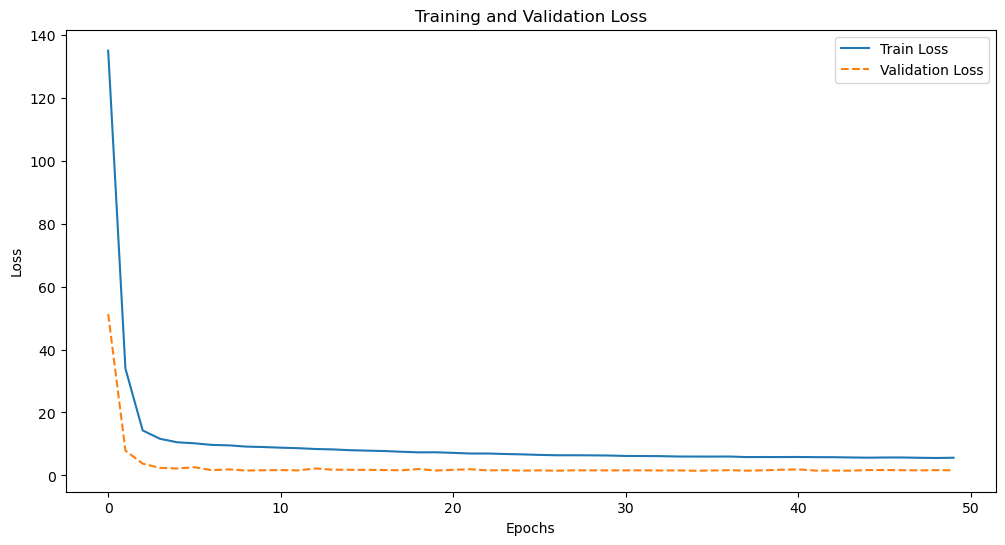

In [53]:
plt.subplots(figsize=(12, 6))

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss', linestyle='--')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [54]:
val_loss = evaluate(model, val_loader, criterion, device)
test_loss = evaluate(model, test_loader, criterion, device)

print("Evaluation on val/test dataset")
print("Val loss: ", val_loss)
print("Test loss: ", test_loss)

Evaluation on val/test dataset
Val loss:  1.6193493065054747
Test loss:  1.4008090656204342


In [57]:
def plot_difference(y, pred):
    plt.figure(figsize=(20, 6))
    times = range(len(y))
    y_to_plot = y.flatten()
    pred_to_plot = pred.flatten()
    
    plt.plot(times, y_to_plot, color="steelblue", marker="o", label="True value")
    plt.plot(times, pred_to_plot, color="orangered", marker="X", label="Prediction")
    
    plt.title("Temperature in every hours")
    plt.xlabel("Hour")
    plt.ylabel("Temperature (C)")
    plt.legend()
    plt.show()

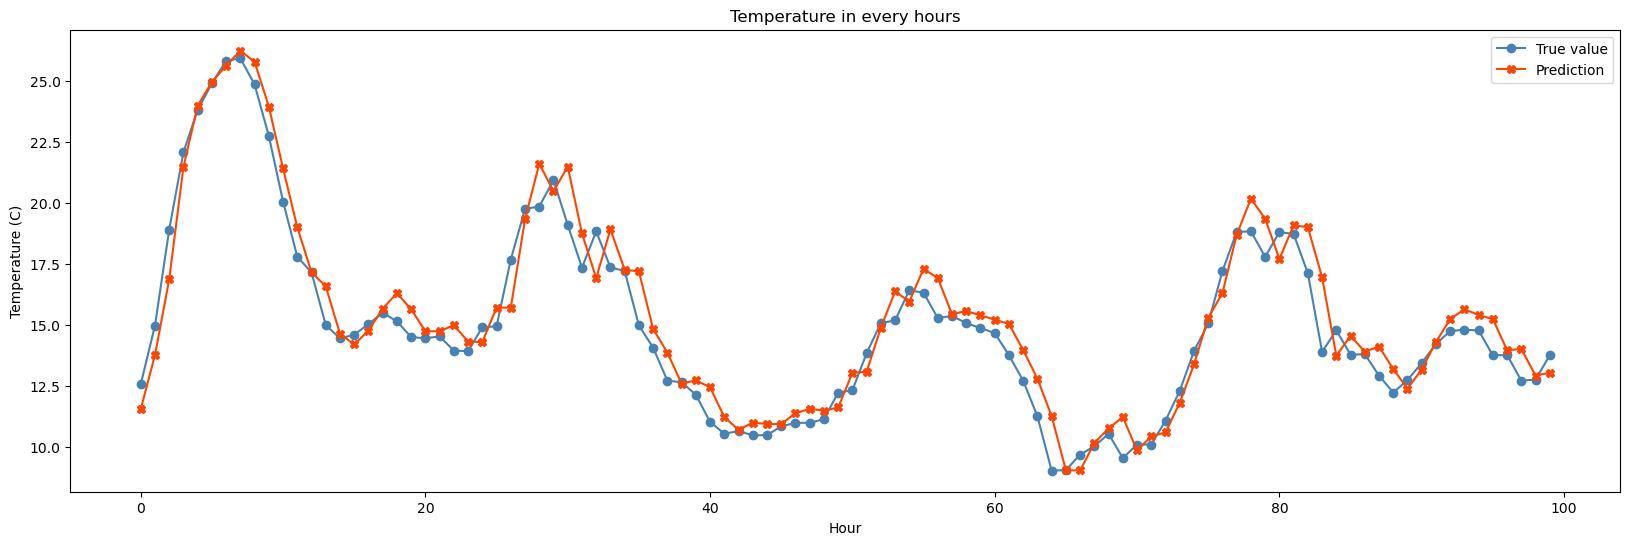

In [58]:
inputs = torch.tensor(X_test[:100], dtype=torch.float32).to(device)
model.eval()
with torch.no_grad():
    outputs = model(inputs).detach().cpu().numpy()

plot_difference(y_test[:100], outputs)

In [60]:
input_tensor = torch.randn(5, 10, 10)

lstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=2, batch_first=True)
bilstm = nn.LSTM(input_size=10, hidden_size=20, num_layers=2, batch_first=True, bidirectional=True)

output_lstm, (hidden_state_lstm, cell_state_lstm) = lstm(input_tensor)

output_bilstm, (hidden_state_bilstm, cell_state_bilstm) = bilstm(input_tensor)

print(output_lstm.shape)
print(output_bilstm.shape)

torch.Size([5, 10, 20])
torch.Size([5, 10, 40])
